In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy 
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')
np.set_printoptions(suppress = True)

# Trainng Samples loaded from Github Repo
ratings_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/ratings.dat'
titles_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/movies.dat'

ratings = pd.read_csv(ratings_path, sep  = "::", names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
titles = pd.read_csv(titles_path, sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding ='latin-1')
data = pd.merge(ratings, titles, on='MovieID')

ntotal = data.shape[0]
ntrain = int(np.floor(ntotal*0.85))
ntest = ntotal - ntrain

print(f"ntotal: {ntotal}\nntrain: {ntrain}\nntest: {ntest}")

data.head()

ntotal: 1000209
ntrain: 850177
ntest: 150032


,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [2]:
np.random.seed(42)
shuffled_data = data.reindex(np.random.permutation(data.index))

train = deepcopy(shuffled_data)
test = deepcopy(shuffled_data)

train['Rating'][ntrain:] = -1
test['Rating'][:ntrain] = -1

train_mtx = train.pivot_table(index='UserID', columns='Title', values='Rating')
test_mtx = test.pivot_table(index='UserID', columns='Title', values='Rating')

train_mtx = train_mtx.values
test_mtx = test_mtx.values

train_mtx[train_mtx == -1] = np.nan
test_mtx[test_mtx == -1] = np.nan

train_select = ~(np.isnan(train_mtx))
test_select = ~(np.isnan(test_mtx))

print(np.shape(test_mtx), np.shape(train_mtx))
print(np.shape(test_select), np.shape(train_select))

train.head()

(6040, 3706) (6040, 3706)
(6040, 3706) (6040, 3706)


,UserID,MovieID,Rating,Timestamp,Title,Genres
895536,5755,184,3,958280246,Nadja (1994),Drama
899739,4585,519,3,964321944,Robocop 3 (1993),Sci-Fi|Thriller
55687,1503,3114,4,974762175,Toy Story 2 (1999),Animation|Children's|Comedy
63727,2166,648,4,974614593,Mission: Impossible (1996),Action|Adventure|Mystery
822011,3201,2178,5,968626301,Frenzy (1972),Thriller


In [3]:
test['Rating'][:ntrain] = np.nan
test.dropna(inplace = True)
test.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres
750152,3821,1218,4.0,975104845,"Killer, The (Die xue shuang xiong) (1989)",Action|Thriller
336085,4080,3682,3.0,965442548,Magnum Force (1973),Western
845212,4277,2155,5.0,965645457,"Slums of Beverly Hills, The (1998)",Comedy
194076,438,653,4.0,976250166,Dragonheart (1996),Action|Adventure|Fantasy
343179,4186,912,3.0,965328471,Casablanca (1942),Drama|Romance|War


In [4]:
user_means = np.nanmean(train_mtx, axis = 1)
movie_means = np.nanmean(train_mtx, axis = 0)

um = np.nanmean(user_means)
mm = np.nanmean(movie_means)

unan = np.argwhere(np.isnan(user_means))
mnan = np.argwhere(np.isnan(movie_means))

movie_means[mnan] = mm
user_means[unan] = um

print("User Means:")
print("Shape:", user_means.shape)
print(user_means)

print('\nMovie Means')
print("Shape:", movie_means.shape)
print(movie_means)

User Means:
Shape: (6040,)
[4.17021277 3.7027027  3.91111111 ... 3.5625     3.87378641 3.5970696 ]

Movie Means
Shape: (3706,)
[3.03030303 3.35       2.75       ... 3.2407125  2.57142857 3.24928367]


In [0]:
lam = 0.4
[n_users, n_movies] = train_mtx.shape

for i in range(n_users):
  for j in range(n_movies):
    if(np.isnan(train_mtx[i,j])):
      train_mtx[i,j] = lam*user_means[i] + (1-lam)*movie_means[j]


In [0]:
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error as mae

tmax = 11
MAE = []
reconstruction = deepcopy(train_mtx)
for t in range(tmax):
  U, sigma, Vt = svds(reconstruction, 50)
  sigma = np.diag(sigma)

  reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
  reconstruction[train_select] = train_mtx[train_select]

  reconstruction[reconstruction > 5] = 5
  reconstruction[reconstruction < 0.5] = 0.5
  
  result = reconstruction[test_select].flatten() 
  ground_truth = test_mtx[test_select].flatten()

  MAE.append(mae(result,ground_truth))

Minimum MAE: 0.6973
Maximum MAE: 0.7087


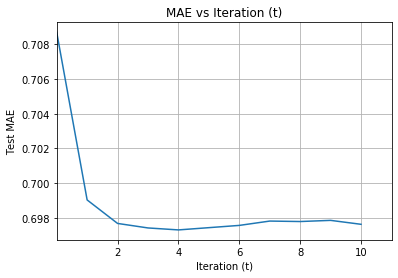

In [7]:
plt.plot(list(range(tmax)), MAE)
plt.xlabel('Iteration (t)')
plt.ylabel('Test MAE')
plt.xticks(np.arange(2, tmax, 2))
plt.xlim(0,tmax)
plt.title("MAE vs Iteration (t)")
plt.grid()

print("Minimum MAE:", "{0:0.4f}".format(min(MAE)))
print("Maximum MAE:", "{0:0.4f}".format(max(MAE)))

In [8]:
reconstruction

array([[3.5, 3.5, 3.5, ..., 3.5, 3. , 3.5],
       [3.5, 3.5, 3. , ..., 3.5, 3. , 3.5],
       [3.5, 3.5, 3. , ..., 3.5, 3. , 3.5],
       ...,
       [3. , 3.5, 3. , ..., 3.5, 3. , 3.5],
       [3.5, 3.5, 3. , ..., 3.5, 3. , 3.5],
       [3. , 3.5, 3. , ..., 3.5, 3. , 3. ]])

In [9]:
[nuser, nmovie] = np.shape(reconstruction)

dataset = []
for u in range(nuser//2):
  for m in range(nmovie//2):
    dataset.append([u,m, reconstruction[u,m]]) 

dataset = np.array(dataset)
print(dataset)

[[   0.     0.     3.5]
 [   0.     1.     3.5]
 [   0.     2.     3.5]
 ...
 [3019.  1850.     3. ]
 [3019.  1851.     4. ]
 [3019.  1852.     4. ]]


In [0]:
# Trainng Samples loaded from Github Repo
titles_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/movies.dat'
users_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/users.dat'

ratings = pd.DataFrame(data=dataset, index=dataset[0:,0],  columns=['UserID', 'MovieID', 'Rating'])
titles = pd.read_csv(titles_path, sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding ='latin-1')
users = pd.read_csv(users_path, sep = "::", names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip Code'], encoding ='latin-1')

users.dropna(inplace=True)

In [11]:
all_genres = []
for index,row in titles.iterrows():
  #  separate the genres and put into a list
  temp = row.Genres.split('|')
   #  store all the genres into a list
  all_genres =  all_genres + temp
  # unique genres list
genres = list(set(all_genres))
lenGeneres = len(genres)
zeroVec = np.zeros(lenGeneres) 
#  store the genres and corresponding index into a dictionary
genreDict0 = dict(enumerate(genres))
#  store genres as key and index as value
genreDict = {value:key for key, value in genreDict0.items()}
print(genreDict)


{'Documentary': 0, "Children's": 1, 'Adventure': 2, 'Film-Noir': 3, 'Musical': 4, 'Animation': 5, 'Romance': 6, 'Action': 7, 'Mystery': 8, 'Western': 9, 'War': 10, 'Thriller': 11, 'Drama': 12, 'Fantasy': 13, 'Crime': 14, 'Sci-Fi': 15, 'Horror': 16, 'Comedy': 17}


In [12]:
genreArray = np.empty([titles.shape[0],lenGeneres])
oldidx = -1
for index,row in titles.iterrows():
  try:
    # create a zeros list
    genresVec = np.zeros(lenGeneres)
    # get genres
    genreTmp = row.Genres.split('|')

    for gen in genreTmp: 
        # get genres index
      genID = genreDict[gen]
      # assign the corresponding genres index to 1
      genresVec[genID] = 1

    # put the 0 and 1 vector into a whole matrix representing the genres
    genreArray[index] = genresVec

  except:  
    print("found a bad movie")
print(genreArray.shape)
print(genreArray)

(3883, 18)
[[0. 1. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
print(len(genreArray),titles.shape)

df2 = pd.DataFrame(genreArray, dtype=int, columns=list(genreDict.keys()))
titles = pd.concat([titles, df2], axis=1)
titles.head()

3883 (3883, 3)


,MovieID,Title,Genres,Documentary,Children's,Adventure,Film-Noir,Musical,Animation,Romance,Action,Mystery,Western,War,Thriller,Drama,Fantasy,Crime,Sci-Fi,Horror,Comedy
0,1,Toy Story (1995),Animation|Children's|Comedy,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [14]:
train_movies = pd.merge(ratings, titles, on='MovieID')
train_movies = train_movies.reindex(np.random.permutation(train_movies.index))
test_movies = pd.merge(test, titles, on='MovieID')

train = pd.merge(train_movies, users, on='UserID')
test = pd.merge(test_movies, users, on='UserID')

print(f"ntotal: {ntrain}\nntest: {ntest}")
train.head()

ntotal: 850177
ntest: 150032


,UserID,MovieID,Rating,Title,Genres,Documentary,Children's,Adventure,Film-Noir,Musical,Animation,Romance,Action,Mystery,Western,War,Thriller,Drama,Fantasy,Crime,Sci-Fi,Horror,Comedy,Gender,Age,Occupation,Zip Code
0,2947.0,770.0,4.0,Costa Brava (1946),Drama,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,F,25,0,02138
1,2947.0,200.0,3.5,"Tie That Binds, The (1995)",Thriller,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,F,25,0,02138
2,2947.0,1198.0,3.5,Raiders of the Lost Ark (1981),Action|Adventure,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,F,25,0,02138
3,2947.0,1316.0,3.5,Anna (1996),Drama,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,F,25,0,02138
4,2947.0,1126.0,4.0,Drop Dead Fred (1991),Comedy|Fantasy,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,F,25,0,02138


In [0]:
total_mtx = train.append(test)
user_means = total_mtx.groupby('UserID')['Rating'].mean()
movie_means = total_mtx.groupby('MovieID')['Rating'].mean()

train['user_mean'] = pd.DataFrame(user_means[train['UserID']]).reset_index().drop('UserID',axis=1)
train['movie_mean'] = pd.DataFrame(movie_means[train['MovieID']]).reset_index().drop('MovieID',axis=1)

test['user_mean'] = pd.DataFrame(user_means[test['UserID']]).reset_index().drop('UserID',axis=1)
test['movie_mean'] = pd.DataFrame(movie_means[test['MovieID']]).reset_index().drop('MovieID',axis=1)


In [0]:
train['Male'] = 0 
train['Female'] = 0

train['Male'][train.Gender == 'M'] = 1
train['Female'][train.Gender == 'F'] = 1

test['Male'] = 0 
test['Female'] = 0

test['Male'][test.Gender == 'M'] = 1
test['Female'][test.Gender == 'F'] = 1

In [0]:

# OLS prediction
from sklearn.linear_model import Ridge,LinearRegression

def run_ridge(xtrain,ytrain,xtest,ytest):
  ridge = Ridge(alpha = 0.1, normalize = True, fit_intercept = True)
  ridge.fit(xtrain, ytrain) 
  print("RIDGE")
  pred_train = ridge.predict(xtrain)
  print("Train MAE:", MAE(pred_train, ytrain))
  pred_test = ridge.predict(xtest)
  print("Test MAE:", MAE(pred_test, ytest))


  print("\nRounded")
  pred_train = np.round(2*ridge.predict(xtrain))/2 
  print("Train MAE:", MAE(pred_train, ytrain))
  pred_test = np.round(2*ridge.predict(xtest))/2 
  print("Test MAE:", MAE(pred_test, ytest))
  print()
  
def run_ols(xtrain,ytrain,xtest,ytest):
  ols = LinearRegression(normalize = True, fit_intercept = True)
  ols.fit(xtrain, ytrain)
  print("OLS")
  pred_train = ols.predict(xtrain)
  print("Train MAE:", MAE(pred_train, ytrain))
  pred_test = ols.predict(xtest)
  print("Test MAE:", MAE(pred_test, ytest))


  print("\nRounded")
  pred_train = np.round(2*ols.predict(xtrain))/2 
  print("Train MAE:", MAE(pred_train, ytrain))
  pred_test = np.round(2*ols.predict(xtest))/2 
  print("Test MAE:", MAE(pred_test, ytest))
  print()

In [25]:
from sklearn.metrics import mean_absolute_error as MAE

ytrain = train['Rating']
ytest = test['Rating']

print("Without adding means to the features")
Features = ['Age', 'Occupation', 'Male', 'Female'] + list(genreDict.keys())
xtrain = train[Features]
xtest = test[Features]
run_ols(xtrain,ytrain,xtest,ytest)
run_ridge(xtrain,ytrain,xtest,ytest)
print()

print("Adding user means to the features")
Features_user = deepcopy(Features)
Features_user.append('user_mean')
xtrain = train[Features_user]
xtest = test[Features_user]
run_ols(xtrain,ytrain,xtest,ytest)
run_ridge(xtrain,ytrain,xtest,ytest)
print()

print("Adding both user and movie means to the features")
Features_both = deepcopy(Features_user)
Features_both.append('movie_mean')
xtrain = train[Features_both]
xtest = test[Features_both]
run_ols(xtrain,ytrain,xtest,ytest)
run_ridge(xtrain,ytrain,xtest,ytest)
print()

Without adding means to the features
OLS
Train MAE: 0.4019376167325683
Test MAE: 0.959047697367693

Rounded
Train MAE: 0.3749540466433069
Test MAE: 0.9470446304788311

RIDGE
Train MAE: 0.40180302560036685
Test MAE: 0.9591430466264325

Rounded
Train MAE: 0.3749540466433069
Test MAE: 0.9470446304788311


Adding user means to the features
OLS
Train MAE: 0.3761185026104795
Test MAE: 0.8822375717172112

Rounded
Train MAE: 0.35788353507011644
Test MAE: 0.8774961341580463

RIDGE
Train MAE: 0.3754656282690265
Test MAE: 0.8842170599621513

Rounded
Train MAE: 0.357832847125158
Test MAE: 0.8794190572677829


Adding both user and movie means to the features
OLS
Train MAE: 0.16576591654047257
Test MAE: 0.8400076584125921

Rounded
Train MAE: 0.07110469641448702
Test MAE: 0.8322024634744588

RIDGE
Train MAE: 0.16795426113463838
Test MAE: 0.8356573610677058

Rounded
Train MAE: 0.08112995497870736
Test MAE: 0.8284765916604457




In [0]:
#Create train and test data 
# from sklearn.metrics import mean_absolute_error as MAE

# Features = ['UserID', 'MovieID', 'Age', 'Occupation', 'Male', 'Female'] + list(genreDict.keys())
# xtrain = train[Features]
# ytrain = train['Rating']

# xtest = test[Features]
# ytest = test['Rating']

In [0]:
# # OLS prediction
# from sklearn.linear_model  import LinearRegression
# ols = LinearRegression(normalize = True, fit_intercept = True)
# ols.fit(xtrain, ytrain)

# print("Normal")
# pred_train = ols.predict(xtrain)
# print("Train MAE:", MAE(pred_train, ytrain))
# pred_test = ols.predict(xtest)
# print("Test MAE:", MAE(pred_test, ytest))


# print("\nRounded")
# pred_train = np.round(2*ols.predict(xtrain))/2 
# print("Train MAE:", MAE(pred_train, ytrain))
# pred_test = np.round(2*ols.predict(xtest))/2 
# print("Test MAE:", MAE(pred_test, ytest))

Normal
Train MAE: 0.40184463012028604
Test MAE: 0.9583020618605922

Rounded
Train MAE: 0.3749540466433069
Test MAE: 0.9470446304788311


In [0]:
# # Ridge prediction
# from sklearn.linear_model import Ridge
# ridge = Ridge(alpha = 0.1, normalize = True, fit_intercept = True)
# ridge.fit(xtrain, ytrain) 

# print("Normal")
# pred_train = ridge.predict(xtrain)
# print("Train MAE:", MAE(pred_train, ytrain))
# pred_test = ridge.predict(xtest)
# print("Train MAE:", MAE(pred_test, ytest))


# print("\nRounded")
# pred_train = np.round(2*ridge.predict(xtrain))/2 
# print("Train MAE:", MAE(pred_train, ytrain))
# pred_test = np.round(2*ridge.predict(xtest))/2 
# print("Train MAE:", MAE(pred_test, ytest))

Normal
Train MAE: 0.4017154720569402
Train MAE: 0.9584666447200193

Rounded
Train MAE: 0.3749540466433069
Train MAE: 0.9470446304788311


In [0]:
# # Ridge prediction
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_absolute_error as MAE

# mae_train = []
# mae_test= []
# alphas = np.linspace(0, 2, num=20)
# for a in alphas:
#   ridge = Ridge(alpha = a, normalize = True, fit_intercept = True)
#   ridge.fit(xtrain, ytrain) 

#   pred_train = ridge.predict(xtrain)
#   pred_test = ridge.predict(xtest)

#   mae_train.append(np.min(MAE(pred_train, ytrain)))
#   mae_test.append(np.min(MAE(pred_test, ytest)))


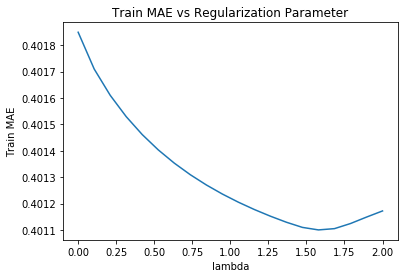

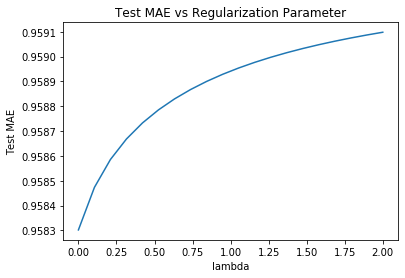

In [0]:
plt.figure()
plt.plot(alphas, mae_train)
plt.xlabel('lambda')
plt.ylabel('Train MAE')
plt.title("Train MAE vs Regularization Parameter")

plt.figure()
plt.plot(alphas, mae_test)
plt.xlabel('lambda')
plt.ylabel('Test MAE')
plt.title("Test MAE vs Regularization Parameter")

print()